In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image, ImageOps
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import cv2
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### **GLCM Feature Extraction**

In [346]:
def glcm_feature_extractor(dataset):
  image_feature = pd.DataFrame()
  distance = [1, 3, 5, 8]
  angle = [0, np.pi/4, np.pi/2, 3*np.pi/4]
  for image in range(dataset.shape[0]):
    img = dataset[image]
    df = pd.DataFrame()
    count = 1
    for dist in distance:
      for ang in angle:
        GLCM = greycomatrix(img, [dist], [ang])      
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df[f'Energy{count}'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df[f'Corr{count}'] = GLCM_corr       
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df[f'Dissim{count}'] = GLCM_diss       
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df[f'Homogen{count}'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df[f'Contrast{count}'] = GLCM_contr
        GLCM_ASM = greycoprops(GLCM, 'ASM')[0]
        df[f'ASM{count}'] = GLCM_ASM
        count = count + 1
    image_feature = image_feature.append(df)    
  return image_feature

### **Load Images**

In [4]:
image_dir = "/gdrive/My Drive/Project/Denoised_CLAHE_Cl3"

In [5]:
def load_data(tag='train'):
  tag_dir = os.path.join(image_dir, tag)
  tag_path = Path(tag_dir)
  data = [] # Images
  cat = [] # Category
  subcat = []
  patient = []
  file_name = []
  for mag_dir in tag_path.iterdir():  
    mag_label = mag_dir.stem
    print("*",mag_label)
    if mag_label == "40X":
      print("Got it!")
      for img_name in mag_dir.glob('*.png'):
        img_label = img_name.stem
        splitted_image_name = img_label.split('_')
        cat_label = splitted_image_name[1]
        remaining_part = splitted_image_name[2].split('-')
        subcat_label = remaining_part[0]
        patient_label = remaining_part[2]
        img = cv2.imread(img_name.as_posix(), 0)
        data.append(img) # append the image to the data
        cat.append(cat_label) # append the label to the category
        subcat.append(subcat_label)
        patient.append(patient_label)
        file_name.append(img_label)
  return data, cat, subcat, patient, file_name

In [6]:
# train images
vec_train, cat_train, subcat_train, patient_train, image_name_train = load_data('train')
# test images
vec_test, cat_test, subcat_test, patient_test, image_name_test = load_data('test')

* 40X
Got it!
* 100X
* 200X
* 400X
* 40X
Got it!
* 100X
* 200X
* 400X


In [7]:
# Convert images into numpy array
vec_train = np.array(vec_train)
vec_test = np.array(vec_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### **Get GLCM Features**

In [347]:
train_features = glcm_feature_extractor(vec_train)
test_features = glcm_feature_extractor(vec_test)

In [348]:
train_features.shape[0]

1250

In [349]:
train_features.shape[1]

96

In [350]:
train_features = np.expand_dims(train_features, axis=0)
train_features_for_ML = np.reshape(train_features, (vec_train.shape[0], -1)) # Reshape to [#images, #features]

test_features = np.expand_dims(test_features, axis=0)
test_features_for_ML = np.reshape(test_features, (vec_test.shape[0], -1)) # Reshape to [#images, #features]

### **List the categories**

In [351]:
# Get unique categories for train data
labels = list(np.unique(np.array(cat_train))) # convert categories to the numpy array and get unique values
labels

['B', 'M']

In [352]:
# Get unique categories for test data
labels = list(np.unique(np.array(cat_test)))
labels

['B', 'M']

### **Label Encoding**

In [353]:
le = LabelEncoder()
label_train = le.fit_transform(cat_train) # Here fit is used to assign 0 or 1
label_test = le.transform(cat_test) # Only transform is used since the fit is already done above

In [354]:
label_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
label_test

### **Function to Compute Patient Recognition Rate**

In [356]:
def evaluate_recognition_rate(prediction):
  inverted_prediction = le.inverse_transform(prediction)
  unique_patient_test = list(np.unique(np.array(patient_test)))
  num_images_per_patient = []
  num_correctly_classified = []
  num = 0
  total_patient_score = 0
  num_patient = 0
  for patient in unique_patient_test:
    num_patient = num_patient + 1
    Np = 0
    Nrec = 0
    image_index_counter = -1
    for image_name in image_name_test:
      image_index_counter = image_index_counter + 1
      image_name_splitted = image_name.split('-')
      if patient == image_name_splitted[2]:
        first_part_splitted = image_name_splitted[0].split('_')
        image_class = first_part_splitted[1]
        if image_class == inverted_prediction[image_index_counter]:
          Nrec = Nrec + 1
        Np = Np + 1
    patient_score = Nrec/Np
    #print(patient_score)
    num_images_per_patient.append(Np)
    num_correctly_classified.append(Nrec)
    total_patient_score = total_patient_score + patient_score
    num = num + Np    
  recognition_rate = total_patient_score/num_patient
  print("Summation of patient score: ", total_patient_score)
  print("Total Number of Patients: ", num_patient)
  print("Recognition Rate: ", recognition_rate)

### **SVM Fit**

In [430]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [431]:
pipe1.fit(train_features_for_ML,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

**Accuracy**

Accuracy: 74.77%


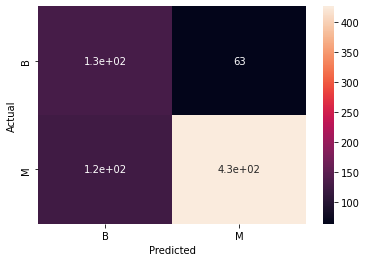

In [432]:
# Test set evaluation
prediction = pipe1.predict(test_features_for_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [360]:
prediction_prob = pipe1.predict_proba(test_features_for_ML)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.733765506202481


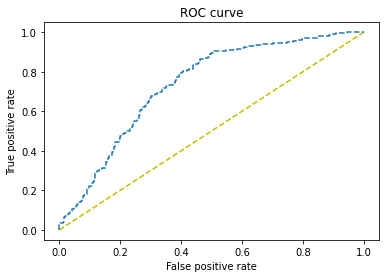

In [361]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [362]:
evaluate_recognition_rate(prediction)

Summation of patient score:  20.94814996593021
Total Number of Patients:  28
Recognition Rate:  0.7481482130689361


### **Random Forest**

In [388]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 42))
                 ])

In [389]:
pipe2.fit(train_features_for_ML,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

**Accuracy**

Accuracy: 68.19%


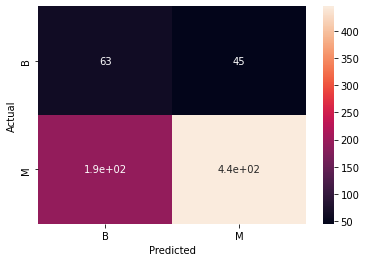

In [390]:
# Test set evaluation
prediction = pipe2.predict(test_features_for_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [391]:
prediction_prob = pipe2.predict_proba(test_features_for_ML)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.642360944377751


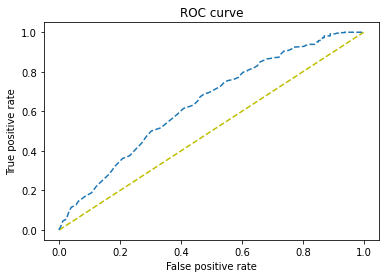

In [392]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [393]:
evaluate_recognition_rate(prediction)

Summation of patient score:  19.510570966253013
Total Number of Patients:  28
Recognition Rate:  0.6968061059376076


### **KNN**

In [400]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [401]:
pipe3.fit(train_features_for_ML,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

**Accuracy**

Accuracy: 67.52%


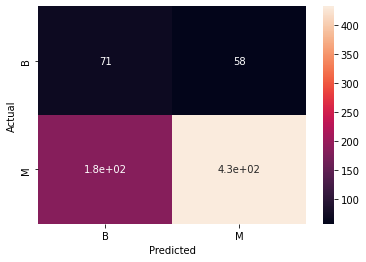

In [402]:
# Test set evaluation
prediction = pipe3.predict(test_features_for_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [403]:
prediction_prob = pipe3.predict_proba(test_features_for_ML)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.6208563425370148


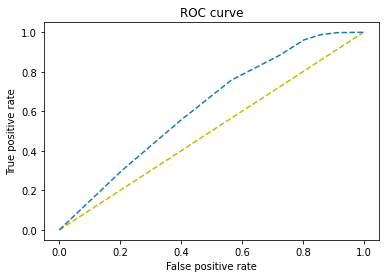

In [404]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [405]:
evaluate_recognition_rate(prediction)

Summation of patient score:  20.386828548852012
Total Number of Patients:  28
Recognition Rate:  0.7281010196018576


### **AdaBoost**

In [406]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(train_features_for_ML,label_train)

AdaBoostClassifier(n_estimators=200, random_state=0)

**Accuracy**

Accuracy: 66.04%


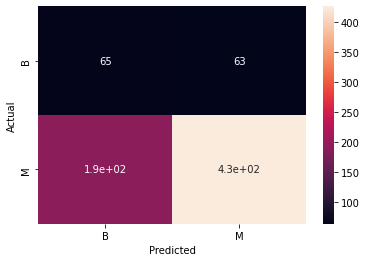

In [407]:
# Test set evaluation
prediction = clf.predict(test_features_for_ML)
# Visualization
cmat = confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [408]:
prediction_prob = clf.predict_proba(test_features_for_ML)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.6414485794317728


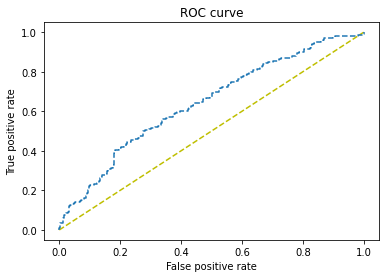

In [409]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [410]:
evaluate_recognition_rate(prediction)

Summation of patient score:  18.53066475275547
Total Number of Patients:  28
Recognition Rate:  0.6618094554555525


### **Xgboost**

In [411]:
"""
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)    
"""
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.1)
vec_train_arr = np.array(train_features_for_ML)
vec_test_arr = np.array(test_features_for_ML)
mod1.fit(vec_train_arr, label_train)

XGBClassifier(booster='dart')

**Accuracy**

In [412]:
prediction = mod1.predict(vec_test_arr)
print("Accuracy = ", accuracy_score(label_test, prediction))

Accuracy =  0.6912751677852349


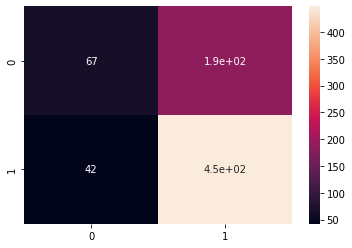

In [413]:
cm = confusion_matrix(label_test, prediction)
sns.heatmap(cm, annot=True)

**Area Under Curve**

In [414]:
prediction_prob = mod1.predict_proba(vec_test_arr)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.6374789915966387


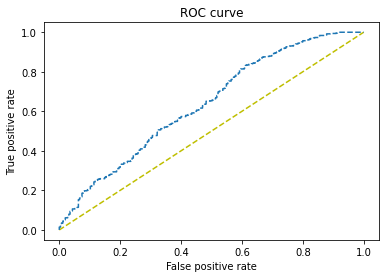

In [415]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [416]:
evaluate_recognition_rate(prediction)

Summation of patient score:  19.827405556817318
Total Number of Patients:  28
Recognition Rate:  0.7081216270291899


### **LightGBM**

In [417]:
scaler = StandardScaler()
vec_train_scaled = scaler.fit_transform(train_features_for_ML)
vec_test_scaled = scaler.transform(test_features_for_ML)
d_train = lgb.Dataset(vec_train_scaled, label=label_train)

In [418]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [419]:
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(vec_test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, vec_test_scaled.shape[0]):
    if prediction[i]>=.5: # setting threshold to 0.5
       prediction[i]=1
    else:  
       prediction[i]=0

**Accuracy**

Accuracy with LGBM =  0.6859060402684564


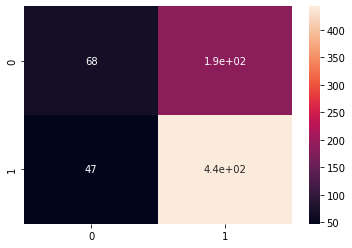

In [420]:
#Print accuracy
print ("Accuracy with LGBM = ", accuracy_score(label_test, prediction))
#Confusion matrix
cm_lgbm = confusion_matrix(label_test, prediction)
sns.heatmap(cm_lgbm, annot=True)

**Area Under Curve**

In [421]:
prediction_prob=clf.predict(vec_test_scaled)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob))

Area under curve (AUC):  0.6236734693877551


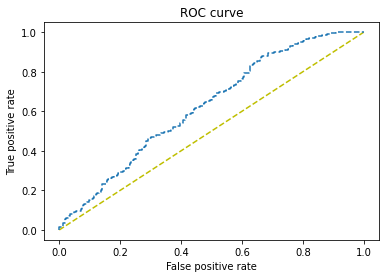

In [422]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [423]:
prediction = prediction.astype(int)
evaluate_recognition_rate(prediction)

Summation of patient score:  19.726062168212405
Total Number of Patients:  28
Recognition Rate:  0.7045022202933001


### **Grid search to find the best model and parameters**

In [343]:
skf = StratifiedKFold(n_splits = 5)

In [344]:
# Defining a dictionary
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [0.1, 1, 5, 10, 100], #Regularization parameter.
            'kernel': ['rbf','linear','sigmoid','poly'], 
            'gamma':[0.00001,0.0001,0.001,0.01,0.1,1]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [30,50,70,100] #Trees: may lead to overfitting if n_estimators is too much
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 5, 9, 15, 19, 23, 27, 31, 35, 39]
        }
    }
}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=skf, n_jobs=6, #five fold cross validation
                         return_train_score=False)
    
    grid.fit(train_features_for_ML,label_train)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)